# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [3]:
import os
#### Add your code here ####
project_path = '/content/drive/My Drive/Deep Learning/Computer Vision/Face Mask Segmentation/'
import sys

!{sys.executable} -m pip install segmentation-models albumentations
%set_env SM_FRAMEWORK=tf.keras
%matplotlib inline

import os
import math
import copy
import numpy as np
np.set_printoptions(threshold=2000)
from IPython.display import display
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Rectangle
import random
random.seed(0)
import cv2

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import segmentation_models as sm
from segmentation_models.utils import set_trainable

from albumentations import (Compose, HorizontalFlip, HueSaturationValue, 
                            RandomBrightness, RandomContrast, RandomGamma, 
                            ShiftScaleRotate, NoOp)
K.set_image_data_format('channels_last')
K.clear_session()

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [4]:
import numpy as np
data = np.load(project_path + 'images.npy', allow_pickle=True)
DATA_FILE = 'images.npy'
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [5]:
#### Add your code here ####
display(data.shape)
display(data[0,0].shape)
display(len(data[0,1]))
display(data[0,1])

(409, 2)

(333, 650, 3)

2

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

Total images in Dataset = 409
Image Data in 1st column and Bounding box in 2nd
BB seem to be in float. Need to Convert them to using image width and height 

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [6]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 16
IMAGE_CHANNELS=3

In [11]:
def display_image(data, title, axis=None):
    if axis is None:
        _, axis = plt.subplots(1)
    if len(data[0].shape) == 2:
        axis.imshow(data[0], cmap='gray')
    else:
        axis.imshow(data[0])

    axis.axis('off')
    axis.set_title("{0}".format(title))
    
    for i in np.arange(len(data[1])):
        width = data[1][i]['imageWidth']
        height = data[1][i]['imageHeight']
        x0 = data[1][i]['points'][0]['x'] * width
        y0 = data[1][i]['points'][0]['y'] * height
        x1 = data[1][i]['points'][1]['x'] * width
        y1 = data[1][i]['points'][1]['y'] * height
        axis.add_patch(Rectangle((x0,y0), x1 - x0 , y1 - y0, linewidth=2, edgecolor='r',facecolor='none'))      

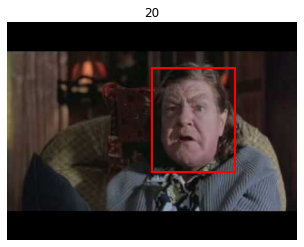

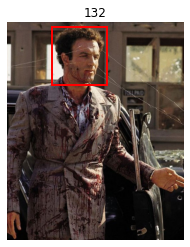

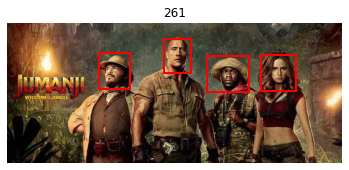

In [12]:
for i in random.sample(list(np.arange(data.shape[0])), 3):
    display_image(data[i,:], i)

Although all faces seem to have a bounding box, 1 missing boxes.

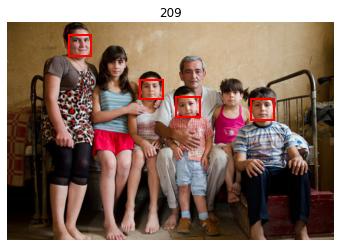

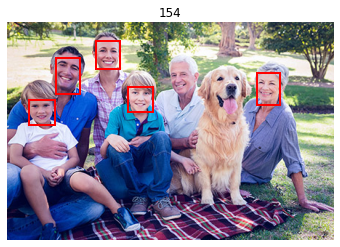

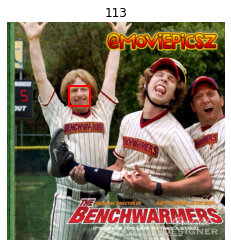

In [13]:
# Let's print some of these outliers
outliers = [8, 17, 19, 41, 44, 57, 58, 62, 88, 113, 126, 129, 154, 157, 208, 209, 213, 215, 267, 268, 276, 306, 341, 362, 381]
for i in random.sample(outliers, 3):
    display_image(data[i,:], i)

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [14]:
def preprocess_images(data, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, channels=IMAGE_CHANNELS):
    """ Preprocess the data. Resize Images, prepare masks and return X and Y """
    #Here feature is the image
    #The label is the mask
    #Images will be stored in "x" array
    #Masks will be stored in "y" array

    data_images = data[:, 0]
    data_masks = data[:, 1]
    
    num_images = data_images.shape[0]
    print("num_images: {}".format(num_images))
    
    images = np.zeros((num_images, width, height, channels), dtype=np.uint8)
    masks = np.zeros((num_images, width, height), dtype=np.uint8)
    
    for i in np.arange(num_images):
        img = data_images[i]
        img_shape = img.shape
        
        if len(img_shape) == 2:
            print("Grayscale image at index: {0}".format(i))
            conv_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif len(img_shape) == 3:
            img_ch = img_shape[2]
            if img_ch == 3:
                conv_img = img
            elif img_ch == 4:
                if np.all(img[:,:,3]) is False:
                    raise Exception("Alpha component for an RGBA image is not 1.0")
                conv_img = img[:, :, 0:3]
            else:
                raise Exception("Invalid number of channels {0}".format(img_ch))
        else:
            raise Exception("Invalid shape of Image data {0}".format(img_shape))


        images[i] = cv2.resize(conv_img, (width, height), interpolation=cv2.INTER_CUBIC)
        
        mask = data_masks[i]
        for j in np.arange(len(mask)):
            x0 = int(mask[j]['points'][0]['x'] * width)
            y0 = int(mask[j]['points'][0]['y'] * height)
            x1 = int(mask[j]['points'][1]['x'] * width) + 1
            y1 = int(mask[j]['points'][1]['y'] * height) + 1
            masks[i][y0:y1, x0:x1] = 1
        
    return (images, masks)

### Print the shape of X_train and mask array  (2 marks)

In [17]:
(x, y) = preprocess_images(data)
display("Shape of images dataset: {0}".format(x.shape))
display("Shape of masks: {0}".format(y.shape))

num_images: 409
Grayscale image at index: 272


'Shape of images dataset: (409, 224, 224, 3)'

'Shape of masks: (409, 224, 224)'

### Print a sample image and image array

In [18]:
"""from matplotlib import pyplot
n = 2
print(X_train[n])
pyplot.imshow(X_train[n])"""

'from matplotlib import pyplot\nn = 2\nprint(X_train[n])\npyplot.imshow(X_train[n])'

In [20]:
#pyplot.imshow(masks[n])

In [21]:
def display_processed_image(x, y, title, axis=None):
    if axis is None:
        _, axis = plt.subplots(1)
    
    axis.set_title("{0}".format(title))
    axis.axis('off')
    axis.imshow(x)
    axis.imshow(y, alpha=0.3, interpolation='none')
  

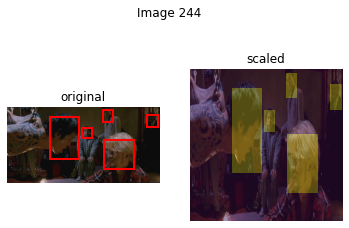

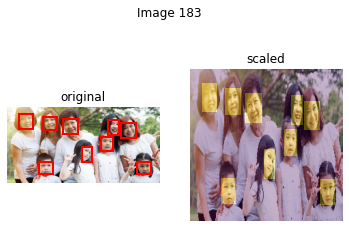

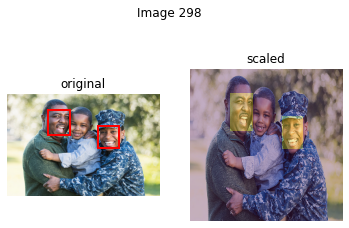

In [22]:
for i in random.sample(list(np.arange(x.shape[0])), 3):
    fig, ax = plt.subplots(1,2)
    display_image(data[i], "original", axis=ax[0])
    display_processed_image(x[i], y[i], "scaled", axis=ax[1])
    fig.suptitle("Image {0}".format(i))

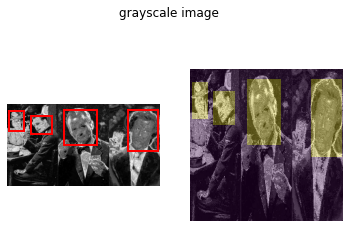

In [23]:
# Grayscale
fig, ax = plt.subplots(1,2)
fig.suptitle("grayscale image")
display_image(data[272], "", axis=ax[0])
display_processed_image(x[272], y[272], "", axis=ax[1])

In [24]:
# Training and validation sets
del data

x_train = x[0:350]
x_val = x[350:]

y_train = y[0:350]
y_val = y[350:]

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [25]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


"""def create_model(trainable=True):
    model = MobileNet(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)), alpha = 1.0)
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    import segmentation_models as sm
    model = sm.Unet('mobilenet', encoder_weights='imagenet')
   
    return model"""
BACKEND = 'mobilenetv2'   
model = sm.Unet(BACKEND, input_shape=(224, 224, 3), encoder_weights='imagenet', decoder_use_batchnorm=True)

# add a reshape layer at the end
last_layer = model.layers[-1].output
op = Reshape((224,224))(last_layer)
model = Model(model.input, op)

# This makes all layers trainable
set_trainable(model, recompile=False)

### Call the create_model function

In [27]:
# make first few mobilenet blocks non-trainable

for layer in model.layers:
    layer.trainable = False
    if "block_10" in layer.name:
        break
# Print summary
model.summary()

# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
#model = create_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [28]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + K.epsilon())

### Define loss

In [29]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

IMAGE AUGMENTATION

In [31]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=BATCH_SIZE, augment=False):
        self.orig_x = x_set
        self.orig_y = y_set
        self.x = copy.deepcopy(self.orig_x)
        self.y = copy.deepcopy(self.orig_y)
        self.batch_size = batch_size
        self.preprocess_input = sm.get_preprocessing(BACKEND)
        if augment:
            self.augment_fn = Compose(
                [
                    HorizontalFlip(p=0.5),
                    RandomContrast(limit=0.2, p=0.2),
                    RandomGamma(gamma_limit=(90, 110), p=0.2),
                    RandomBrightness(limit=0.2, p=0.2),
                    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20, val_shift_limit=10, p=0.2),
                    ShiftScaleRotate(p=0.2),
                ],
                p=1.0)
        else:
            self.augment_fn = Compose([NoOp(p=1.0)], p=1.0)

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x = batch_x.astype(np.float32)

        for i in np.arange(batch_x.shape[0]):
            augmented = self.augment_fn(image=batch_x[i], mask=batch_y[i])
            batch_x[i] = self.preprocess_input(augmented['image'])
            batch_y[i] = augmented['mask']

        return batch_x, batch_y

    def on_epoch_end(self):
        self.x = copy.deepcopy(self.orig_x)
        self.y = copy.deepcopy(self.orig_y)

In [32]:
train_generator = DataGenerator(x_train, y_train, augment=True)
val_generator = DataGenerator(x_val, y_val)
train_evaluator = DataGenerator(x_train, y_train)

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [33]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-7)
model.compile(optimizer=optimizer, loss=loss, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [34]:
"""from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")"""

model_path = "/content/drive/My Drive/Deep Learning/Computer Vision/Face Mask Segmentation/FMS_model.h5"

checkpoint = ModelCheckpoint(model_path, monitor="val_dice_coefficient", mode='max', save_best_only=True, save_weights_only=False)
stop = EarlyStopping(monitor="val_dice_coefficient", min_delta=0.0001, patience=50, mode='max', restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(factor=0.7, patience=10, min_delta=0.0001, min_lr=1e-7)
callbacks = [checkpoint, stop, reduce_lr]

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [35]:
#### Add your code here ####
model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=200,
    steps_per_epoch=math.ceil(len(x_train)/BATCH_SIZE),
    callbacks=callbacks,
)

Epoch 1/200
22/22 [==============================] - 13s 593ms/step - loss: 2.2095 - dice_coefficient: 0.2460 - val_loss: 5.8699 - val_dice_coefficient: 0.2325 - lr: 1.0000e-04
Epoch 2/200
22/22 [==============================] - 7s 329ms/step - loss: 1.9125 - dice_coefficient: 0.2924 - val_loss: 7.1736 - val_dice_coefficient: 0.2464 - lr: 1.0000e-04
Epoch 3/200
22/22 [==============================] - 7s 332ms/step - loss: 1.7555 - dice_coefficient: 0.3150 - val_loss: 8.4042 - val_dice_coefficient: 0.2516 - lr: 1.0000e-04
Epoch 4/200
22/22 [==============================] - 7s 329ms/step - loss: 1.6257 - dice_coefficient: 0.3368 - val_loss: 2.3331 - val_dice_coefficient: 0.4342 - lr: 1.0000e-04
Epoch 5/200
22/22 [==============================] - 6s 279ms/step - loss: 1.5518 - dice_coefficient: 0.3531 - val_loss: 3.3507 - val_dice_coefficient: 0.3821 - lr: 1.0000e-04
Epoch 6/200
22/22 [==============================] - 8s 354ms/step - loss: 1.4541 - dice_coefficient: 0.3719 - val_loss

In [37]:
# Saving the model
model = load_model(model_path, custom_objects={'loss': loss, 'dice_coefficient': dice_coefficient})

#Evaluate the model performance
model.evaluate(x=train_evaluator)   

22/22 [==============================] - 2s 109ms/step - loss: 0.1620 - dice_coefficient: 0.9089


[0.16198895871639252, 0.9089338779449463]

In [38]:
# Evaluating the validation model
model.evaluate(x=val_generator)

4/4 [==============================] - 0s 77ms/step - loss: 0.6731 - dice_coefficient: 0.7155


[0.6730572581291199, 0.7154700756072998]

### Get the predicted mask for a sample image   (5 marks)

In [41]:
#n = 10
#sample_image = X_train[n]
#### Add your code here ####
def display_predictions(x, y, y_pred, img_index):
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Image {0}".format(img_index))

    ax[0].axis('off')
    ax[0].set_title("Original")
    ax[0].imshow(x)
    ax[0].imshow(y, alpha=0.3, interpolation='none')
    
    ax[1].axis('off')
    ax[1].set_title("Prediction")
    ax[1].imshow(x)
    ax[1].imshow(y_pred, alpha=0.3, interpolation='none') 

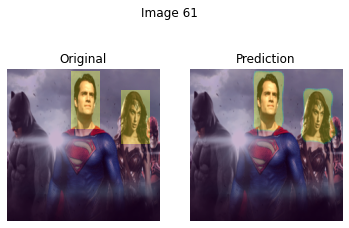

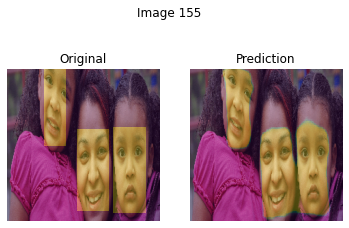

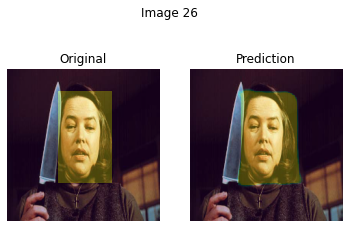

In [42]:
# Training Data 
y_train_pred = model.predict(x=train_evaluator)
for i in random.sample(list(np.arange(x_train.shape[0])), 3):
    display_predictions(x_train[i], y_train[i], y_train_pred[i], i)

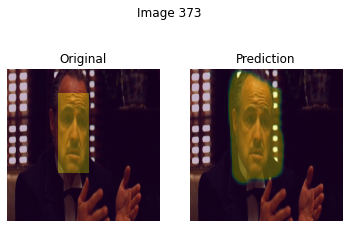

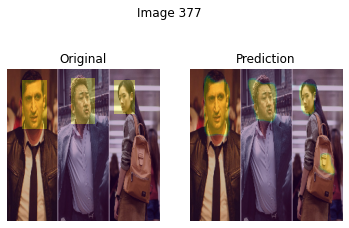

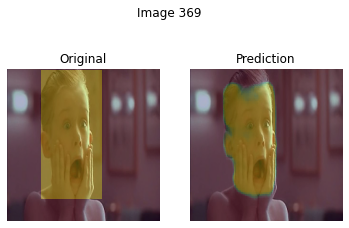

In [43]:
# Validation Data
y_val_pred = model.predict(x=val_generator)
for i in random.sample(list(np.arange(x_val.shape[0])), 3):
    display_predictions(x_val[i], y_val[i], y_val_pred[i], i+350)

### Impose the mask on the image (5 marks)

In [ ]:
#### Add your code here ####